# Pebl Image Processing: "QR" Approach

In [157]:
import numpy as np
import matplotlib.pyplot as plt

In [158]:
def render_image(image):
    plt.figure(figsize=(12, 10), dpi=150)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

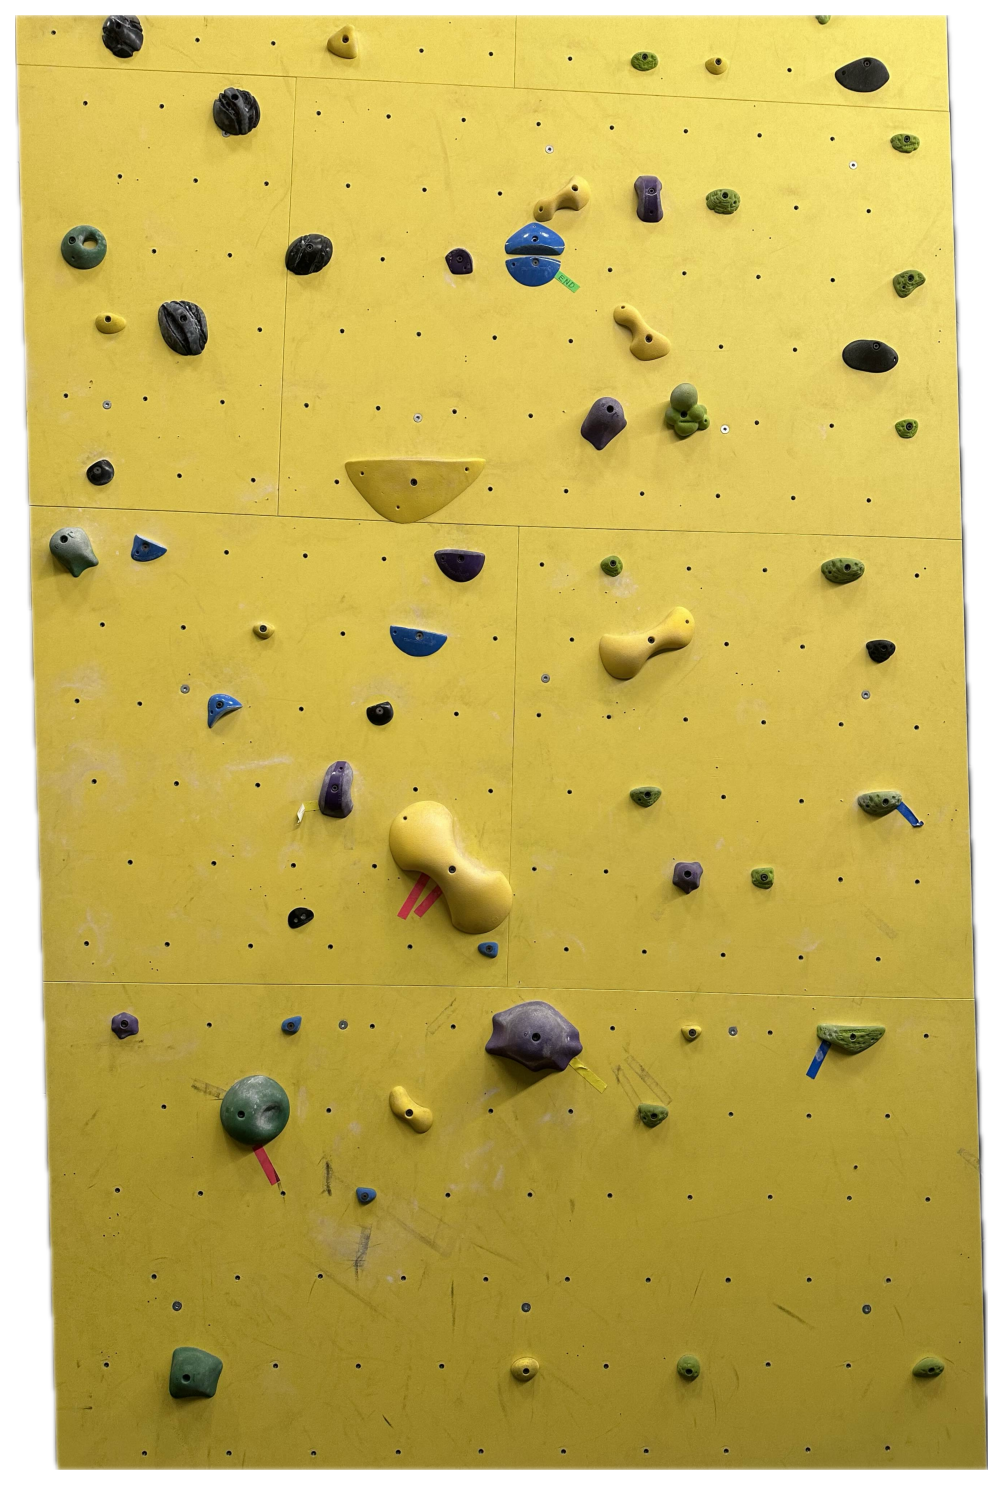

In [159]:
# Display the picture (no edits)
f = plt.imread('images/masked_close_up.png')
render_image(f)

# Smooth

In [160]:
def smooth_image(image, kernel_size=64):
    """
    Process image by dividing it into kernel_size x kernel_size sections
    and applying the average color to each section.
    
    Args:
        image: Input image array (height x width x channels)
        kernel_size: Size of each square section (default: 64)
    
    Returns:
        Processed image with averaged sections
    """
    height, width = image.shape[:2]
    result = image.copy()
    
    # Process each kernel_size x kernel_size section
    for i in range(0, height, kernel_size):
        for j in range(0, width, kernel_size):
            # Define the boundaries of the current section
            i_end = min(i + kernel_size, height)
            j_end = min(j + kernel_size, width)
            
            # Extract the section
            section = image[i:i_end, j:j_end]
            
            # Calculate the average color for this section
            avg_color = section.mean(axis=(0, 1))
            
            # Apply the average color to the entire section
            result[i:i_end, j:j_end] = avg_color
    
    return result

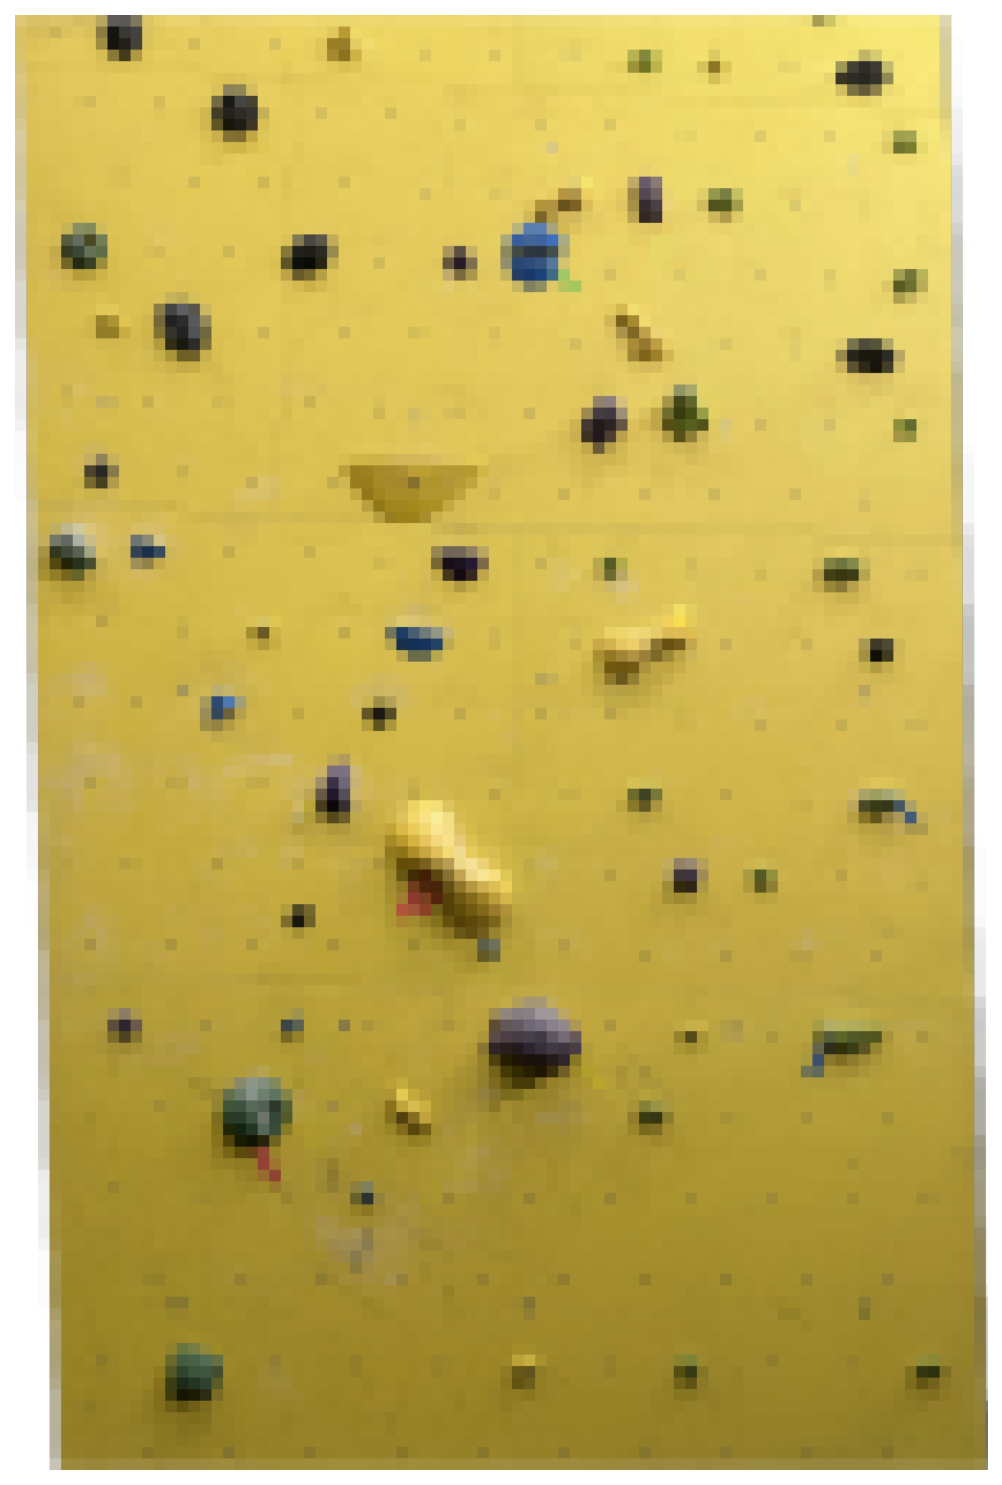

In [161]:
smoothed_image = smooth_image(f, kernel_size=32)
render_image(smoothed_image)

# Strip Background Color
Thought: how effective is this when lighting changes?

In [162]:
def strip_background(image, kernel_size=64, tolerance=0.1):
    """
    Remove background color by finding the most common color in the image
    and making blocks close to that color transparent.
    
    Args:
        image: Input image array (height x width x channels)
        kernel_size: Size of each square section to analyze (default: 64)
        tolerance: How close a block needs to be to the background color (0-1, default: 0.1)
                  Lower values = stricter matching, higher values = more permissive
    
    Returns:
        Image with RGBA channels where background blocks are transparent
    """
    height, width = image.shape[:2]
    
    # Ensure image has alpha channel
    if image.shape[2] == 3:
        # Add alpha channel (fully opaque)
        result = np.dstack([image, np.ones((height, width))])
    else:
        result = image.copy()
    
    # Collect all block average colors
    block_colors = []
    for i in range(0, height, kernel_size):
        for j in range(0, width, kernel_size):
            i_end = min(i + kernel_size, height)
            j_end = min(j + kernel_size, width)
            section = image[i:i_end, j:j_end]
            avg_color = section.mean(axis=(0, 1))
            block_colors.append(avg_color[:3])  # Only RGB channels
    
    # Find the most common color (mode of block colors)
    block_colors = np.array(block_colors)
    # Use k-means or simple rounding to find most common
    # Round to reduce color space and find mode
    rounded_colors = np.round(block_colors * 10) / 10
    unique_colors, counts = np.unique(rounded_colors, axis=0, return_counts=True)
    background_color = unique_colors[np.argmax(counts)]
    
    # Make blocks similar to background color transparent
    for i in range(0, height, kernel_size):
        for j in range(0, width, kernel_size):
            i_end = min(i + kernel_size, height)
            j_end = min(j + kernel_size, width)
            section = image[i:i_end, j:j_end]
            avg_color = section.mean(axis=(0, 1))[:3]
            
            # Calculate color distance (Euclidean distance in RGB space)
            color_distance = np.linalg.norm(avg_color - background_color)
            
            # If close enough to background color, make transparent
            if color_distance < tolerance:
                result[i:i_end, j:j_end, 3] = 0  # Set alpha to 0 (transparent)
    
    return result

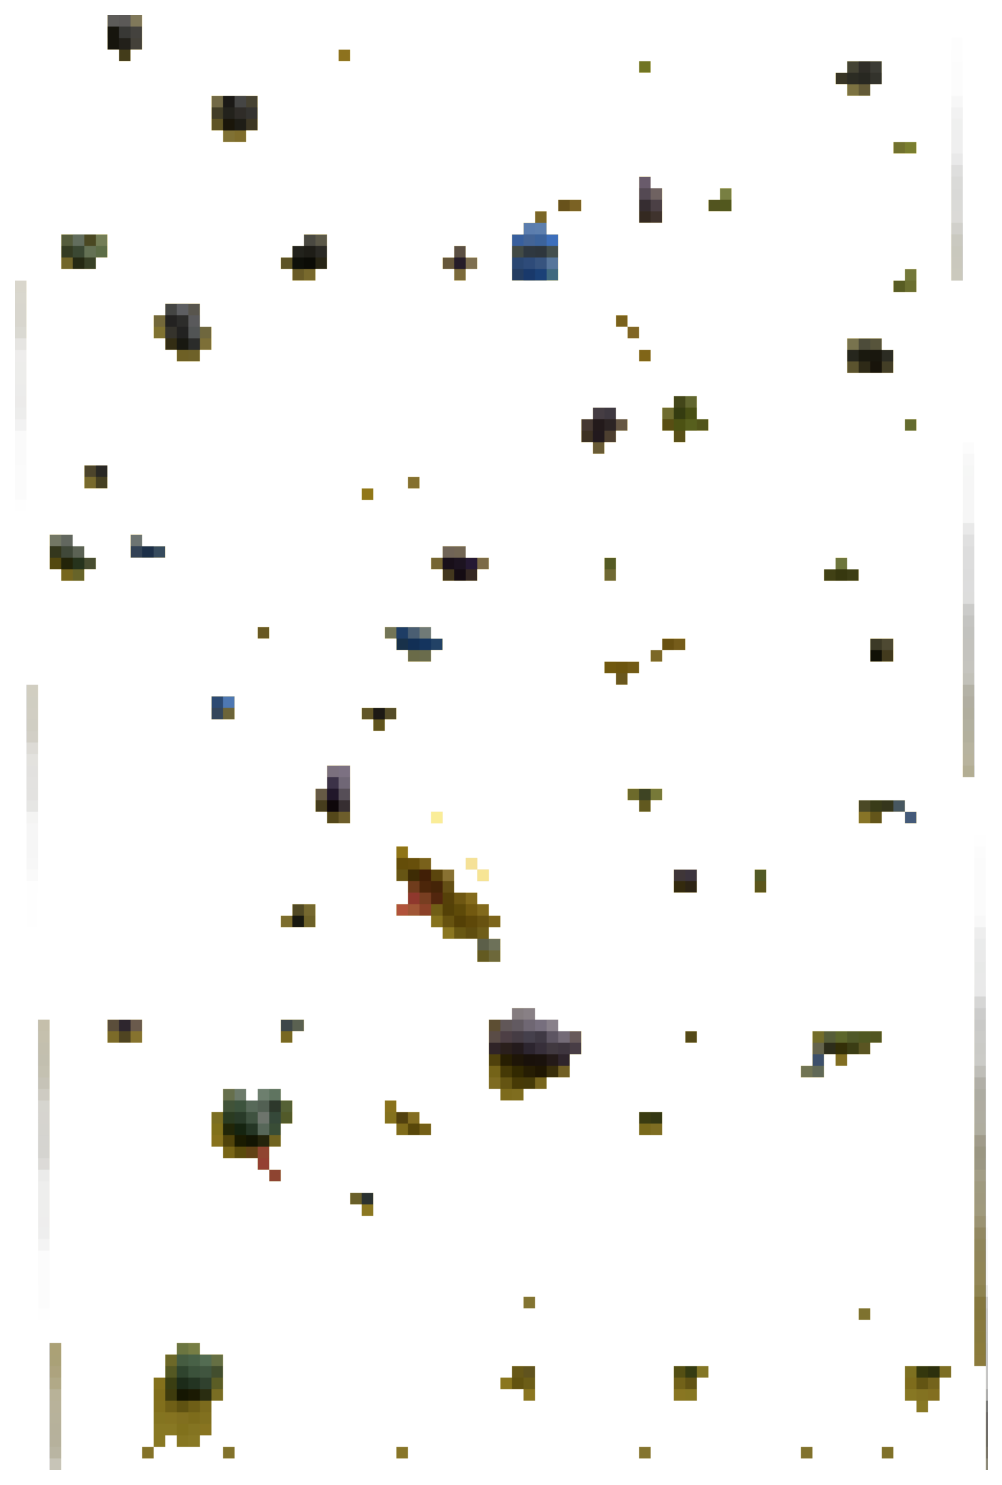

In [163]:
stripped_image = strip_background(smoothed_image, kernel_size=32, tolerance=0.38)
render_image(stripped_image)

# Boost Contrast
(Not currently used)

In [164]:
import cv2

def boost_contrast(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Boost image contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization).
    
    Args:
        image: Input image array (height x width x channels)
        clip_limit: Threshold for contrast limiting (default: 2.0)
        tile_grid_size: Size of grid for histogram equalization (default: (8, 8))
    
    Returns:
        Image with enhanced contrast
    """
    # Convert to uint8 if needed (0-255 range)
    if image.max() <= 1.0:
        img_uint8 = (image * 255).astype(np.uint8)
    else:
        img_uint8 = image.astype(np.uint8)
    
    # Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # Convert to LAB color space for better results
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    
    # Apply CLAHE to L channel
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    
    # Convert back to RGB
    result = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    # Return in same format as input
    if image.max() <= 1.0:
        return result.astype(np.float64) / 255.0
    else:
        return result

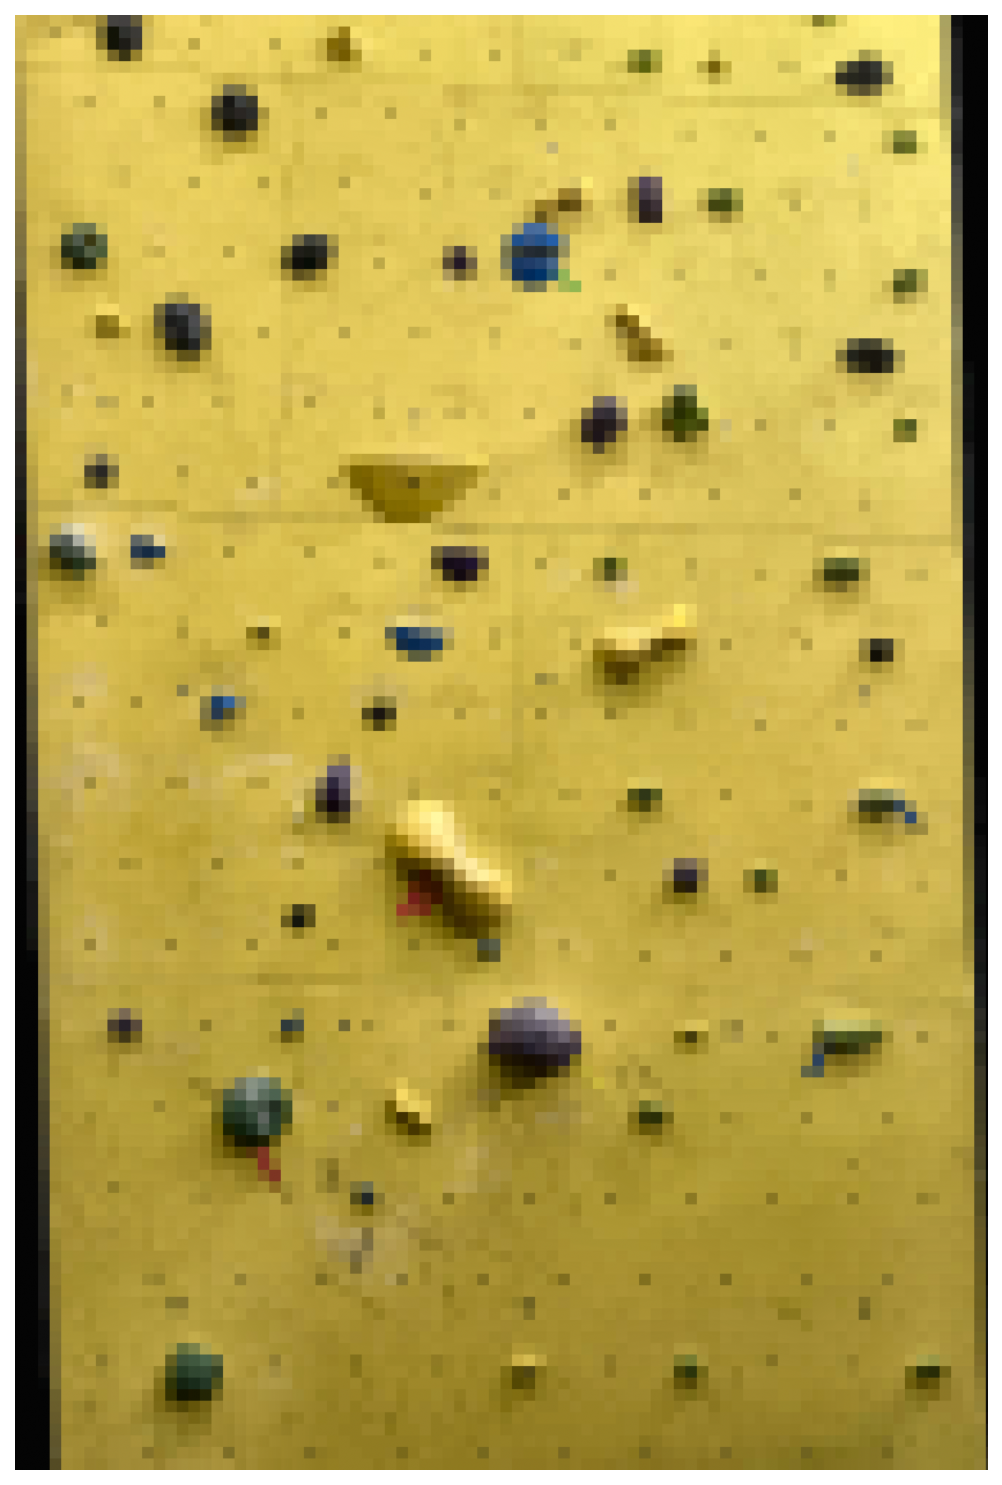

In [ ]:
# contrasted_image = boost_contrast(stripped_image, clip_limit=2.0, tile_grid_size=(8, 8))
# render_image(contrasted_image)

# Subdivide Image into Vertical Columns

# Working Notes
- use **vertical** sections of the wall to compute the hash? This seems to make more sense for climbing walls, and will make hashing more consistent when we correct image orientation later
- We can use similar sections of the wall that we've seen before to compute where we are in the gym (future)
- I don't like the background stripping approach too much, since it inevitably won't work very well for different sections of the wall with different lighting and colors
- Idea to try next: instead of stripping bg, round every color to the nearest in a fixed palette of colors (e.g., 16 colors)